In [1]:
import process as pc
from IPython.core.interactiveshell import InteractiveShell

from sklearn.svm import LinearSVC
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
import cv2
import gc

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
positive_images_path = pc.DATA_PATH+"/img_align_celeba"
negative_images_path = pc.DATA_PATH+"/caltech-101/101_ObjectCategories"

pc.extract_dataset(positive_images_path)
bad_imgs_path_list = pc.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


In [3]:
n_good_images = 15000
n_bad_images_folder=1000
size_w = size_h = 96

#count bad images:
bad_img_list = set()
for fld in bad_imgs_path_list:
    tmp_img_list = pc.load_images(negative_images_path+"/"+fld, number_of_images=n_bad_images_folder, random_seed=7)
    for img in tmp_img_list:
        img_path = negative_images_path+"/"+fld+'/'+img
        bad_img_list.add(img_path)

len(bad_img_list)

/home/enrico/Machine_learning/face_detection_project/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


8275

In [4]:
choices = ['HOG', 'SIFT', 'ORB']
print("Choose feature extractor:", flush=True)
for i, choice in enumerate(choices):
    print("{}. {}".format(i+1, choice), flush=True)
choice_features_extractor = str(input())
choice_features_extractor= choice_features_extractor.upper()


if choice_features_extractor in choices:
    idx = choices.index(choice_features_extractor.upper())+1
else:
    print("Invalid choice")
    exit(1)
print("You chose: {}. {}".format(idx, choice_features_extractor.upper()), flush=True)

Choose feature extractor:
1. HOG
2. SIFT
3. ORB
You chose: 1. HOG


In [5]:
bad_patches = pc.extract_patches(bad_img_list, (size_w, size_h), n_patches=18000, random_seed=7)
len(bad_patches)
img_list = pc.load_images(positive_images_path, number_of_images=n_good_images, random_seed=7) 
dataset = np.empty((n_good_images+len(bad_patches), size_w, size_h), dtype=np.uint8)
good_img_len = 0

1


15919

In [6]:
#if choice_features_extractor.upper() == 'ORB' or choice_features_extractor.upper() == 'SIFT':
for i, img in enumerate(img_list):
    image = cv2.imread(pc.DATA_PATH+"/img_align_celeba/"+img)
    dataset[i, ...] = pc.process_image(image, resize=True, img_resize=(size_w, size_h))
    good_img_len += 1

for i, img in zip(range(len(bad_patches)), bad_patches):
    dataset[good_img_len+i, ...] = pc.process_image(img, resize=True, img_resize=(size_w, size_h))

#else:
#    for i, img in enumerate(img_list):
#        image = cv2.imread(pc.DATA_PATH+"/img_align_celeba/"+img, cv2.IMREAD_GRAYSCALE)
#        dataset[i, ...] = cv2.resize(image, (size_w, size_h))
#        good_img_len += 1
#
#    for i, img in zip(range(len(bad_patches)), bad_patches):
#        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#        dataset[good_img_len+i, ...] = cv2.resize(gray, (size_w, size_h))

In [7]:
del tmp_img_list, img_list, bad_img_list, bad_patches
gc.collect()

0

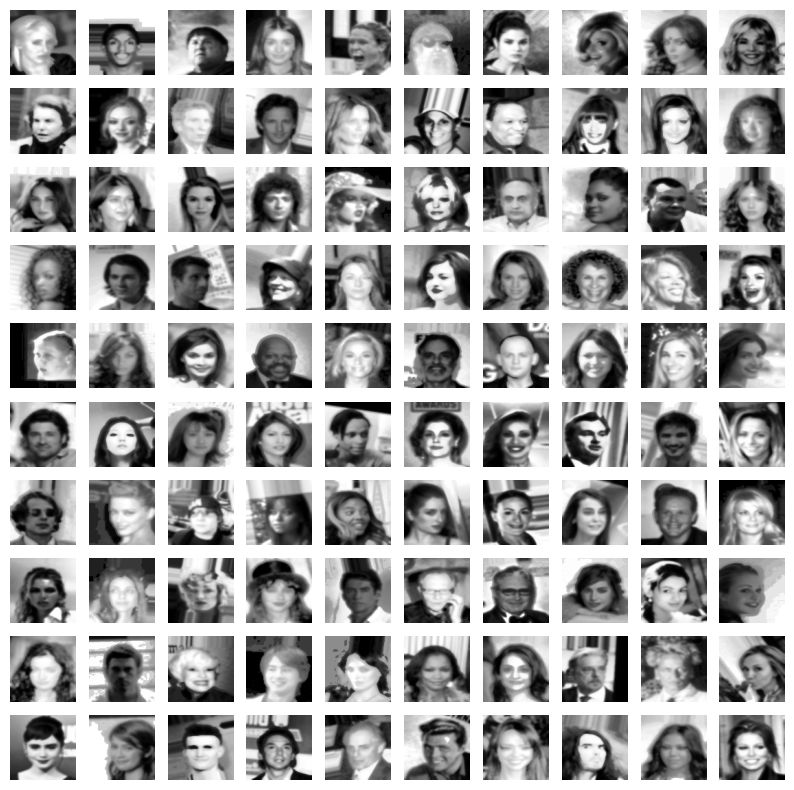

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(dataset[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

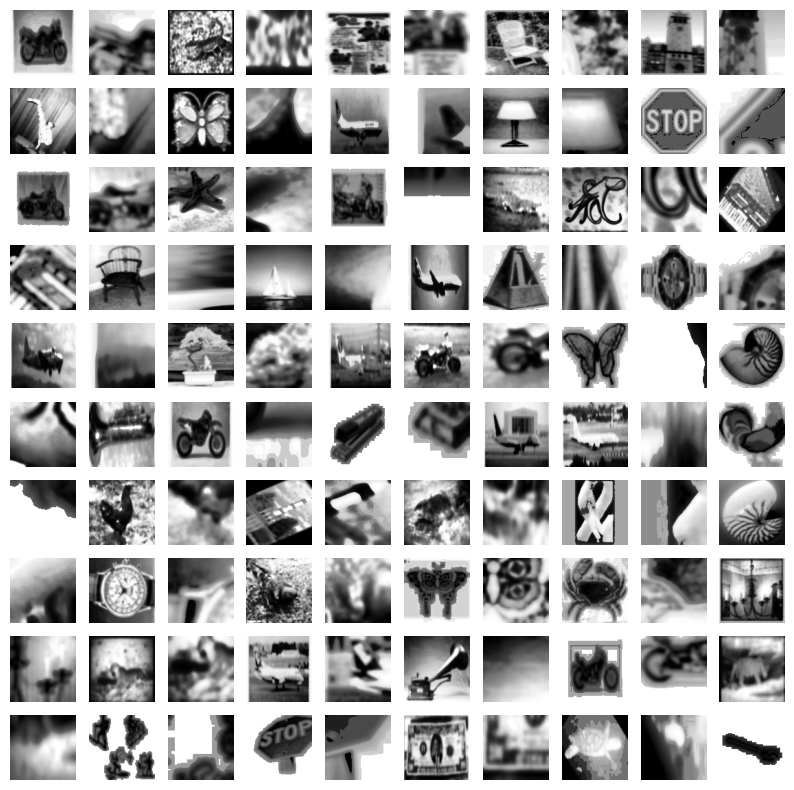

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(dataset[good_img_len+i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

In [10]:
dataset.shape

(30919, 96, 96)

In [11]:
good_samples = n_good_images
bad_samples = dataset.shape[0] - good_samples
n_keypoints = 32
n_features = 128#256
ftr_shape = n_keypoints*n_features
features = None
X = np.empty((good_samples+bad_samples, 8100), dtype=np.float64)
l = 0

for i, img in enumerate(dataset):
   if choice_features_extractor == "ORB":
      _, features = pc.extract_ORB_features(img, n_keypoints=32)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "SIFT":
      kp, features = pc.extract_SIFT_features(img, n_optimal_keypoints=n_keypoints)
      if len(kp) < n_keypoints:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "HOG":
      ftr_shape = 8100
      features = pc.extract_HOG_features(img)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
      
   features = features.flatten()
   if features.shape[0] == ftr_shape:
      X[l, ...] = features
      l += 1 
   else:
      if i < good_samples:
         features.shape
         print("good sample")
         good_samples -= 1
      else:
         print("bad sample")
         bad_samples -= 1

In [12]:
good_samples
bad_samples
if l < good_samples+bad_samples:
    X = X[:l, ...]
y = np.concatenate((np.ones(good_samples), np.zeros(bad_samples))) 
X.shape
y.shape

15000

15919

(30919, 8100)

(30919,)

In [13]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=7)

In [14]:
#del X, y

In [15]:
#X_train.shape
#y_train.shape
#X_train[0]
#y_train[0]


In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X[0]
X.shape
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)
#X_train[0]

array([0.16528064, 0.        , 0.        , ..., 0.01214344, 0.05493147,
       0.        ])

(30919, 8100)

In [17]:
param_grid = {  'C' : [np.power(10., i) for i in range(-2, 2)],
                'max_iter' : [5000],
                'random_state' : [7],
                'dual' : ['auto']
             }

grid_searh = GridSearchCV(LinearSVC(), param_grid, cv=7, n_jobs=4)
grid_searh.fit(X, y)
#grid_searh.fit(X_train, y_train)
grid_searh.best_params_

GridSearchCV(cv=7, estimator=LinearSVC(), n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1.0, 10.0], 'dual': ['auto'],
                         'max_iter': [5000], 'random_state': [7]})

{'C': 0.01, 'dual': 'auto', 'max_iter': 5000, 'random_state': 7}

In [18]:
best_svc = grid_searh.best_estimator_

best_svc.score(X, y)
#best_svc.score(X_train, y_train)
#best_svc.score(X_test, y_test)

0.9980594456483068

In [19]:
#y_pred = best_svc.predict(X_train)
#accuracy = accuracy_score(y_train, y_pred)
y_pred = best_svc.predict(X)
accuracy = accuracy_score(y, y_pred)

print("Accuracy train:", accuracy)


#y_pred = best_svc.predict(X_test)
#accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy test:", accuracy)

Accuracy train: 0.9980594456483068


In [20]:
pipeline_save_path = pc.DATA_PATH+"/hog_features_preprocess.pkl"

from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('preprocess', pc.process_image),
        ('normalize', scaler),
        ('extract_features', pc.extract_HOG_features),
        ('svc', best_svc)  
    ])

joblib.dump(
    pipeline, pipeline_save_path
    )

['../data/hog_features_preprocess.pkl']